In [1]:
# make some imports and display a distoted corrected image 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [3]:
def color_thresh(img, thresh=(0, 255), channel='g'):
    """
    Threshold color
    
    Apply a threshold color in some channels of some color spaces
    """
    # Convert to grayscale
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if channel == 'h':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,0]
    if channel == 'l':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,1]
    if channel == 's':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2]
    if channel == 'v':
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        gray = luv[:,:,2]
    
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gray)
    # Apply threshold
    dir_binary[(gray>thresh[0]) & (gray<thresh[1])] = 1
    
    return dir_binary

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), channel='gray'):
    """
    Calculate directional gradient
    
    Calculate the gradient in x or y with sobel in some 
    channel of some space color
    """
    
    # Convert to grayscale
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if channel == 'h':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,0]
    if channel == 'l':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,1]
    if channel == 's':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls[:,:,2]
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1 , 0, ksize = sobel_kernel)
    if orient =='y':
        grad = cv2.Sobel(gray, cv2.CV_64F, 0 , 1, ksize = sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_grad = np.absolute(grad)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_abs_grad = np.uint8(255 * abs_grad / np.max(abs_grad))
    # Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scale_abs_grad)
    # Apply threshold
    grad_binary[(scale_abs_grad > thresh[0]) & (scale_abs_grad < thresh[1])] = 1
    
    return grad_binary

# Test on Videos

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [6]:
def process_image(img):
    """
    STEP 2: Apply distortion correction to raw images
    """
    # load the calibratios parameters
    with open('calibration_parameters.p', mode='rb') as f:
        data = pickle.load(f)
    mtx, dist = data['cameraMatrix'], data['distCoeffs']
    # Undistortion on an image
    undst_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    """
    STEP 3: Create a thresholding binary image
    """
    # Apply each of the thresholding functions
    yellow_line = color_thresh(undst_img, thresh=(160, 255), channel='v')
    white_line = color_thresh(undst_img, thresh=(205, 255), channel='l')
    gradx = abs_sobel_thresh(undst_img, orient='x', sobel_kernel=3, thresh=(30, 80), channel = 'gray')

    # Combine all in one 
    binary = np.zeros_like(gradx)
    binary[(yellow_line == 1) | (white_line == 1) | (gradx == 1)] = 1
    
    """
    STEP 4: Bird-eye view tranformatation
    """
    #Define four points
    down_limit = undst_img.shape[0]
    up_limit = 450
    lx_down = 0
    lx_up = 595 - 60 + 39
    rx_up = undst_img.shape[1] - lx_up
    rx_down = undst_img.shape[1] - lx_down
    
    # Polyline with the four points 
    vertices = np.array([[(lx_down, down_limit),
                          (lx_up,up_limit),
                          (rx_up,up_limit),
                          (rx_down, down_limit)]], dtype=np.int32)
    
    # Set all pixels out of the region iqual to zero in the binary image
    binary = region_of_interest(binary,vertices)

    # Transform calculation
    img_size = (binary.shape[1], binary.shape[0])
    # four source coordinates
    src = np.float32(
        [[lx_down, down_limit],
         [lx_up,up_limit],
         [rx_up,up_limit],
         [rx_down, down_limit]])
    # Four desired coordinates
    d = 550
    dst = np.float32(
        [[lx_down + d, down_limit],
         [lx_down + d, 0],
         [rx_down - d, 0],
         [rx_down - d, down_limit]])

    # compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    # compute the inverse  perspective transform, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp an image using the perspective transform, M
    binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    
    
    """
    Step 4: Detect lane pixels
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 6
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
        
    # Step through the windows one by one
    for window in range(nwindows):
        #window = 4
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        #plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(good_left_inds[:5])
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    #print(left_lane_inds)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/73 # meters per pixel in y dimension
    xm_per_pix = 3.7/128 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Finding your offset from lane center
    left_line = leftx[0]
    right_line = rightx[0]
    vehicle_center = img.shape[1]/2
    lane_width = right_line - left_line
    lane_center = left_line + lane_width/2
    offset = (vehicle_center - lane_center) * xm_per_pix
    
    # estimate the curvature of a imaginary center line with interpolation
    xp = [left_line, right_line]
    fp = [left_curverad, right_curverad]
    center_curverad = np.interp(lane_center, xp, fp)
    
    # Write the info; curvature and desviation from the center on the undistorte image
    text = ('Radius of Curvature = %d m' % center_curverad)
    cv2.putText(undst_img, text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2) 
    text = ('Offset =  %.2f m' % offset)
    cv2.putText(undst_img, text, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)

    
    """
    Step 5: Warp the detected line boundaries onto the original image
    """    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undst_img, 1, newwarp, 0.3, 0)

    return result

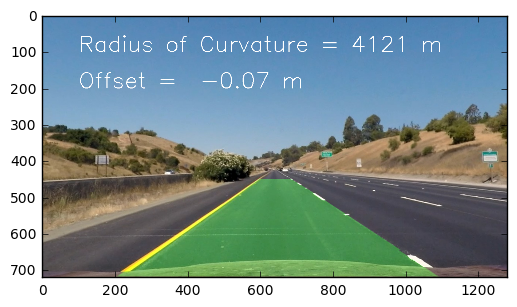

In [7]:
# This is to vew that the ouput "process_image" function is ok
%matplotlib inline
fname = 'straight_lines1.jpg'
img = mpimg.imread('test_images/' + fname)
r = process_image(img)
plt.imshow(r)

In [8]:
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:41<00:00,  6.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 3min 43s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
